In [1]:
# -*- coding: utf-8 -*-

# 本代码主要思路是利用ARIMA算法做时间序列预测
# 预测目标是2019年5月15日A股闭市时招商银行600036的股价
# 考虑到影响股价的因素的复杂性，以及金融投资的反身性理论，本次预测使用的数据只有close的时间序列。更多的数据并没有什么用。

# In[ ]:

# 导入必须的模块
import tushare as ts  #使用的公开的数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as sts

import wconfig as wc  #自定义输出控制模块，与本次竞赛无关
wc.dispy() 

# 导入数据，从去年4月开始即可
data = ts.get_hist_data('600036', start='2018-01-08', end='2019-05-10').sort_index()
#data = ts.get_hist_data('600036', start='2018-04-01').sort_index().reset_index()

# 数据安全和源数据备份
#data.to_excel('600036.xlsx')


# 源数据可靠性
print('tushare中5月10日close股价为: %.2f元，与实际不符！' % (data['close']['2019-05-10']))
data['close']['2019-05-10']=33.61
print('当日实际收盘价应为: %.2f元' % data['close']['2019-05-10'])

# 只取 close 字段作为训练数据
train = data['close']
train.index = pd.to_datetime(train.index)  # 将字符串索引转换成时间索引
train.tail()
train.tail().index

tushare中5月10日close股价为: 33.48元，与实际不符！
当日实际收盘价应为: 33.61元


DatetimeIndex(['2019-05-06', '2019-05-07', '2019-05-08', '2019-05-09',
               '2019-05-10'],
              dtype='datetime64[ns]', name='date', freq=None)

In [2]:
# In[]:

#使用ADF单位根检验法检验时间序列的稳定性
#先做一个编译器
def tagADF(t):
    result = pd.DataFrame(index=[
            "Test Statistic Value", "p-value", "Lags Used", 
            "Number of Observations Used", 
            "Critical Value(1%)", "Critical Value(5%)", "Critical Value(10%)"
        ],columns=['value']
    )
    result['value']['Test Statistic Value']=t[0]
    result['value']['p-value']=t[1]
    result['value']['Lags Used']=t[2]
    result['value']['Number of Observations Used'] = t[3]
    result['value']['Critical Value(1%)']=t[4]['1%']
    result['value']['Critical Value(5%)']=t[4]['5%']
    result['value']['Critical Value(10%)']=t[4]['10%']
    print('t is:', t)
    return result

In [3]:
# In[]:

# adfuller：全称 Augmented Dickey–Fuller test， 即扩展迪基-福勒检验，用来测试平稳性
# adfuller检验是检查时间序列平稳性的统计测试之一。 这里的零假设是TS是非平稳的。 
# 测试结果包括测试统计和差异置信水平的一些关键值。 如果'测试统计'小于'临界值'，我们可以拒绝原假设并说该序列是平稳的。
adf_data = sts.adfuller(train)
tagADF(adf_data)

t is: (-1.7325346908056185, 0.4144323576685054, 0, 322, {'1%': -3.4508226600665037, '5%': -2.870558121868621, '10%': -2.571574731684734}, 523.9067372199033)


,value
Test Statistic Value,-1.733
p-value,0.414
Lags Used,0
Number of Observations Used,322
Critical Value(1%),-3.451
Critical Value(5%),-2.871
Critical Value(10%),-2.572


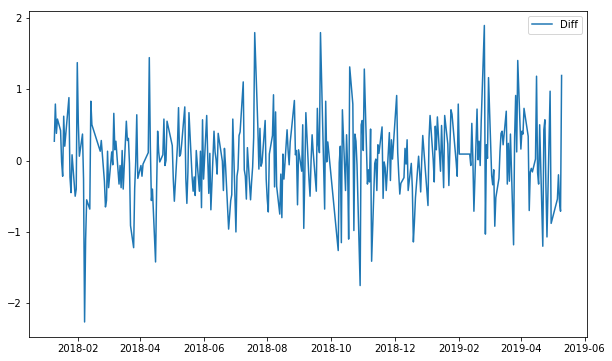

In [4]:
# In[]:
# df.diff 差分运算，默认是后一行减前一行
# http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.diff.html?highlight=diff#pandas.DataFrame.diff
diff = train.diff(1).dropna()  # df.dropna 删除有缺失值的行
#diff = np.log(data[['open']])
plt.figure(figsize=(10,6))  # 指定显示大小
plt.plot(diff, label='Diff')  # 绘制趋势图
#plt.plot(data)  # 绘制趋势图
plt.legend(loc=0)  # 显示图例，loc指定图例位置，0为最佳位置。

In [5]:
# In[]:
# 验证差分数据的平稳性，和第一次验证方法相同
adf_Data1 = sts.adfuller(diff)
tagADF(adf_Data1)  # p-value很小，我们的假设失效，因此，diff数据序列符合平稳性要求。

t is: (-6.042598709673752, 1.3349183393813075e-07, 8, 313, {'1%': -3.4514162625887037, '5%': -2.8708187088091406, '10%': -2.5717136883095675}, 524.3382716511194)


,value
Test Statistic Value,-6.043
p-value,0.000
Lags Used,8
Number of Observations Used,313
Critical Value(1%),-3.451
Critical Value(5%),-2.871
Critical Value(10%),-2.572


In [ ]:
# In[]:
# ARMA(p,q)是AR(p)和MA(q)模型的组合，关于p和q的选择，一种方法是观察自相关图ACF和偏相关图PACF, 
# 另一种方法是通过借助AIC、BIC统计量自动确定。 
ic = sm.tsa.arma_order_select_ic(
    train, 
    max_ar=6, 
    max_ma=6, 
    ic=['aic', 'bic', 'hqic']
)
ic

D:\program\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\program\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


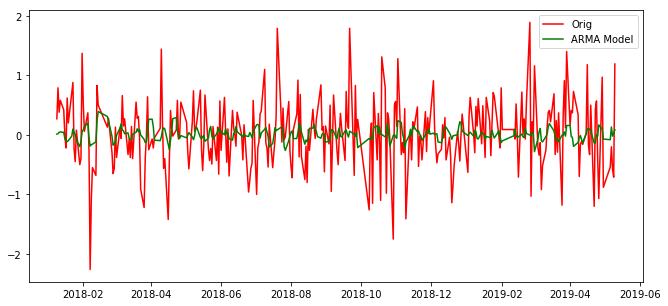

In [12]:
# In[]:
ARMAModel = sm.tsa.ARIMA(train, order=(4,1,2)).fit()  # p=4, q=2
# ARIMA的参数中，输入数据train应该是原始数据，d=1的时候，
# ARIMA会对train先做一个差分运算，然后再拟合数据。
# 拟合出来的数据和diff是接近的，而和原数据train差一个差分还原运算。

# fittedvalues和diff对比
plt.figure(figsize=(11, 5))
plt.plot(diff, 'r', label='Orig')
plt.plot(ARMAModel.fittedvalues, 'g',label='ARMA Model')
plt.legend()

322
score:
 0.9498355377417154


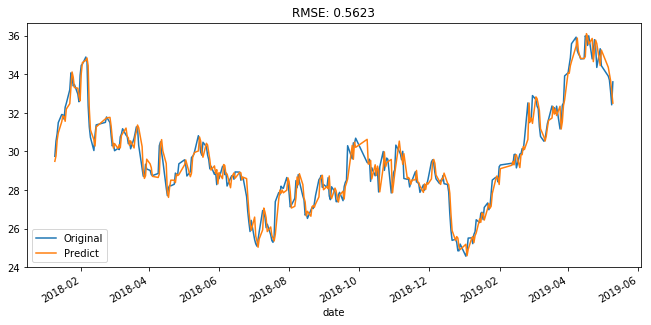

In [13]:
# 样本内预测
predicts = ARMAModel.predict()
print(len(predicts))

# 因为预测数据是根据差分值算的，所以要对它一阶差分还原
train_shift = train.shift(1)  # shift是指series往后平移1个时刻
pred_recover = predicts.add(train_shift).dropna()  #这里add是指两列相加，按index对齐

# 模型评价指标：score
delta = ARMAModel.fittedvalues - diff
score = 1 - delta.var()/train.var()
print('score:\n', score)

# 使用均方根误差（RMSE）来评估模型样本内拟合的好坏。
#利用该准则进行判别时，需要剔除“非预测”数据的影响。
train_vs = train[pred_recover.index]  # 过滤没有预测的记录
plt.figure(figsize=(11, 5))
train_vs.plot(label='Original')
pred_recover.plot(label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_recover-train_vs)**2)/train_vs.size))
plt.show()

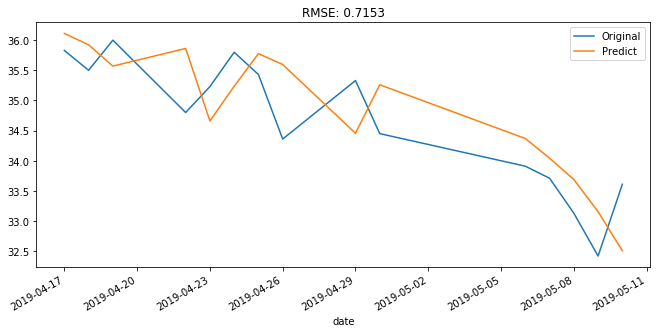

In [14]:
# 局部数据观察
train_t = train_vs.tail(15)
pred_t = pred_recover.tail(15)
plt.figure(figsize=(11, 5))
train_t.plot(label='Original')
pred_t.plot(label='Predict')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((pred_t-train_t)**2)/train_t.size))
plt.show()

In [15]:
# In[]:
# 预测15日close股价，即10日之后的第三个交易日的收盘价
# 但是通过局部数据观察发现，预测的数据趋势会延迟1个工作日，所以就取f[0][1]
f = ARMAModel.forecast(3)
print('5月15日close时的股价为：%.2f 元' % f[0][1])

5月15日close时的股价为：33.82 元


In [ ]:
#

# In[]:
#定阶
pmax = int(len(train)/10)  #一般阶数不超过length/10
qmax = int(len(train)/10)

pmax = 6
qmax = 6
bic_matrix = []  #bic矩阵

for p in range(pmax+1):
    tmp=[]
    for q in range(qmax+1):
        try:
            b_r = sm.tsa.ARIMA(train, (p,1,q)).fit().bic
            print('b_r:\n', b_r)
            tmp.append(b_r)
        except:
            tmp.append(None)
    bic_matrix.append(tmp)

bic_matrix = pd.DataFrame(bic_matrix)

#p,q = bic_matrix.stack().idxmin()  #先用stack展平，然后用idxmin找出最小值位置。
#print(u'BIC最小的P值和q值为：%s、%s' % (p,q))




# In[]:




# In[]
关于foreast和predict的区别：
这个方法今天才弄明白这两个之间的区别，foreast进行预测是对样本外的数据进行预测，predict可以对样本内和样本外的进行预测，结果是一样的。
举例说明：foreast（10），表示对未来10个点进行预测，但是可以用model.fittedvalues查看样本内点的拟合值；
而predict(start,end)里面的参数0表示样本内的第一个数，以此类推。如果想要预测样本外的数，需要将start设置为len(data)+1,即数据长度+1，才表示预测样本外的第一个数字。
但是这两个函数的预测结果是一样的，我做过一个实验，这个arima一般只能预测一点点，越长越不准确，即便是简单的正弦函数也不能准确预测。就说这么多了

# In[]:
# tushare的官方文档
#http://tushare.org/trading.html
#https://tushare.pro/document/2?doc_id=27

#python时间序列预测股票走势
#https://www.jianshu.com/p/d78ce35e42c0

#用Python做股市数据分析（一）
#http://python.jobbole.com/87813/

#Python基于皮尔逊系数实现股票预测
#https://www.cnblogs.com/yszd/p/10058475.html

#Python中利用LSTM模型进行时间序列预测分析
#https://www.cnblogs.com/arkenstone/p/5794063.html

#利用ARIMA进行时间序列数据分析（Python 很详细）
# https://blog.csdn.net/u012735708/article/details/82460962

#Python时间序列实战之ARIMA股票预测
#https://blog.csdn.net/qq_40707407/article/details/81938941

#Python预测股票走势
#https://blog.csdn.net/dipizhong7224/article/details/79252029

#Python 股票价格预测（以中兴通讯为例）
#https://blog.csdn.net/weixin_43181891/article/details/82627766


帝魔微著
Terry天琼(yantaocn)
钟家福(wx806959084)
付(fzzdwxh)
菡萏泉柔(lixiaobeilily1314)

https://github.com/NoneFire/6036datagroup